In [2]:
import bq  
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import matplotlib.dates as mdates

client = bq.Client.Get()

In [3]:
# create a bounding box:
max_lat = 80
min_lat = -80
max_lon = 180
min_lon = -180

In [4]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [7]:
q = '''SELECT
  INTEGER(FLOOR(a.lat)) lat_bin,
  INTEGER(FLOOR(a.lon)) lon_bin,
  SUM(a.hours) hours,
  SUM(a.hours*b.length) weighted_hours,
  SUM(a.hours*b.length)/SUM(a.hours) avg_length
FROM (
  SELECT
    *
  FROM (select*
    FROM (
      SELECT
        mmsi,
        lat,
        lon,
        hours,
        seg_id
      FROM
        TABLE_DATE_RANGE([world-fishing-827:pipeline_classify_logistic_715_fishing.],TIMESTAMP("2015-01-01"),TIMESTAMP("2015-12-31"))
        WHERE lat > '''+str(min_lat)+'''
       AND lat <'''+str(max_lat)+'''
       AND lon > '''+str(min_lon)+'''
       AND lon < '''+str(max_lon)+''' and measure_new_score > .5)
       where     
      seg_id NOT IN (
      SELECT
        seg_id
      FROM
        [scratch_david_seg_analysis_661b.2015_segments]
      WHERE
        (point_count<20
          AND terrestrial_positions = point_count)
        OR ((min_lon >= 0 // these are almost definitely noise
            AND max_lon <= 0.109225)
          OR (min_lat >= 0
            AND max_lat <= 0.109225) )) ) a
  JOIN (
    SELECT
      *
    FROM (
      SELECT
        mmsi,
        AVG(length) length,
      FROM (
        SELECT
          mmsi,
          to_bow + to_stern length,
        FROM
          TABLE_DATE_RANGE([world-fishing-827:pipeline_classify_logistic_715.],TIMESTAMP("2015-01-01"),TIMESTAMP("2015-12-31")))
      WHERE
        length > 2
        AND length < 200
        AND mmsi IN (
        SELECT
          mmsi
        FROM
          [scratch_david_mmsi_lists.known_likely_fishing_mmsis_2016])
      GROUP BY
        mmsi)) b
  ON
    a.mmsi = b.mmsi)
GROUP BY
  lat_bin,
  lon_bin'''

lengths = Query(q)

cellsize = 1
one_over_cellsize = 1

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1

grid_fishing = np.zeros(shape=(num_lats,num_lons))

for row in lengths:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid_fishing[lat_index][lon_index] = float(row[4])


Waiting on bqjob_r442f88320fa68523_00000156132e74fa_3 ... (0s) Current status: DONE   
Query time: 6.36849999428 seconds.


In [29]:
q = '''SELECT
  INTEGER(FLOOR(a.lat)) lat_bin,
  INTEGER(FLOOR(a.lon)) lon_bin,
  SUM(a.hours) hours,
  SUM(a.hours*b.length) weighted_hours,
  SUM(a.hours*b.length)/SUM(a.hours) avg_length
FROM (
  SELECT
    *
  FROM (select*
    FROM (
      SELECT
        mmsi,
        lat,
        lon,
        hours,
        seg_id
      FROM
        TABLE_DATE_RANGE([world-fishing-827:pipeline_classify_logistic_715_fishing.],TIMESTAMP("2015-01-01"),TIMESTAMP("2015-12-31"))
        WHERE lat > '''+str(min_lat)+'''
       AND lat <'''+str(max_lat)+'''
       AND lon > '''+str(min_lon)+'''
       AND lon < '''+str(max_lon)+''' )
       where     
      seg_id NOT IN (
      SELECT
        seg_id
      FROM
        [scratch_david_seg_analysis_661b.2015_segments]
      WHERE
        (point_count<20
          AND terrestrial_positions = point_count)
        OR ((min_lon >= 0 // these are almost definitely noise
            AND max_lon <= 0.109225)
          OR (min_lat >= 0
            AND max_lat <= 0.109225) )) ) a
  JOIN (
    SELECT
      *
    FROM (
      SELECT
        mmsi,
        AVG(length) length,
      FROM (
        SELECT
          mmsi,
          to_bow + to_stern length,
        FROM
          TABLE_DATE_RANGE([world-fishing-827:pipeline_classify_logistic_715.],TIMESTAMP("2015-01-01"),TIMESTAMP("2015-12-31")))
      WHERE
        length > 2
        AND length < 200
        AND mmsi IN (
        SELECT
          mmsi
        FROM
          [scratch_david_mmsi_lists.known_likely_fishing_mmsis_2016])
      GROUP BY
        mmsi)) b
  ON
    a.mmsi = b.mmsi)
GROUP BY
  lat_bin,
  lon_bin'''


lengths = Query(q)

cellsize = 1
one_over_cellsize = 1

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1


grid = np.zeros(shape=(num_lats,num_lons))

for row in lengths:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[4])


In [8]:
def makeMap(grid,fig_title,fig_min_value,fig_max_value):
    plt.rcParams["figure.figsize"] = [12,9]

    firstlat = max_lat
    lastlat =  min_lat
    firstlon = min_lon
    lastlon = max_lon
    scale = cellsize

    numlats = int((firstlat-lastlat)/scale+.5)
    numlons = int((lastlon-firstlon)/scale+.5)

    lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
    lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

    fig = plt.figure()
    extra = 0
    m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
              llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="h")

    m.drawmapboundary()#fill_color='#111111')
#     m.drawcoastlines(linewidth=.2)
    m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)

    x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
    y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
    x, y = np.meshgrid(x, y)
    converted_x, converted_y = m(x, y)
    from matplotlib import colors,colorbar

    maximum = fig_max_value # grid.max()
    minimum = fig_min_value #1

#     norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    norm = colors.Normalize(vmin=0, vmax=200)

    m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

    t = fig_title
    plt.title(t, color = "#000000", fontsize=18)

    ax = fig.add_axes([0.2, 0.1, 0.65, 0.02]) #x coordinate , 
#     norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    norm = colors.Normalize(vmin=minimum, vmax=maximum)
#     lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('viridis'))# ticks=lvls

    #cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
#     cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
    cb.set_label('Average Length of Vessels in Meters',labelpad=-40, y=0.45, color = "#000000")
#     plt.savefig(fig_title+".png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
    plt.show()

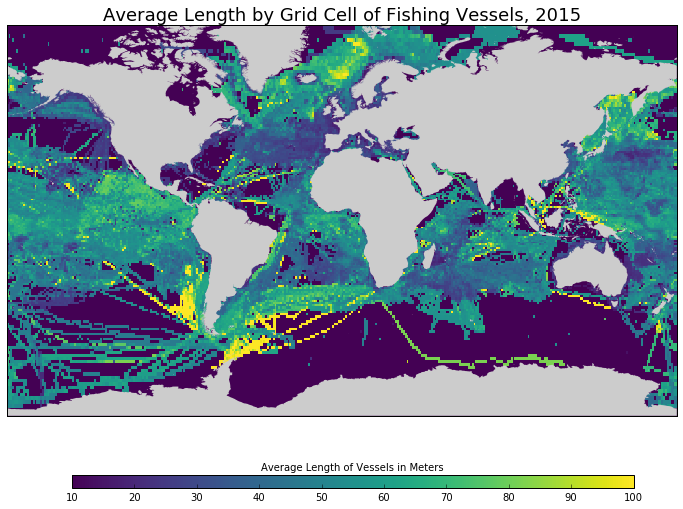

In [52]:
makeMap(grid,"Average Length by Grid Cell of Fishing Vessels, 2015",10,100)

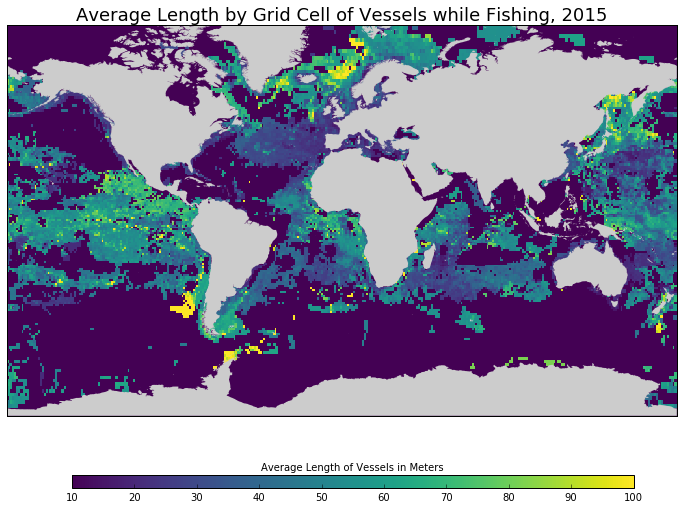

In [9]:
makeMap(grid_fishing,"Average Length by Grid Cell of Vessels while Fishing, 2015",10,100)

In [46]:
grid2 = np.copy(grid).flatten()
# grid2[grid2 == 0] = np.nan

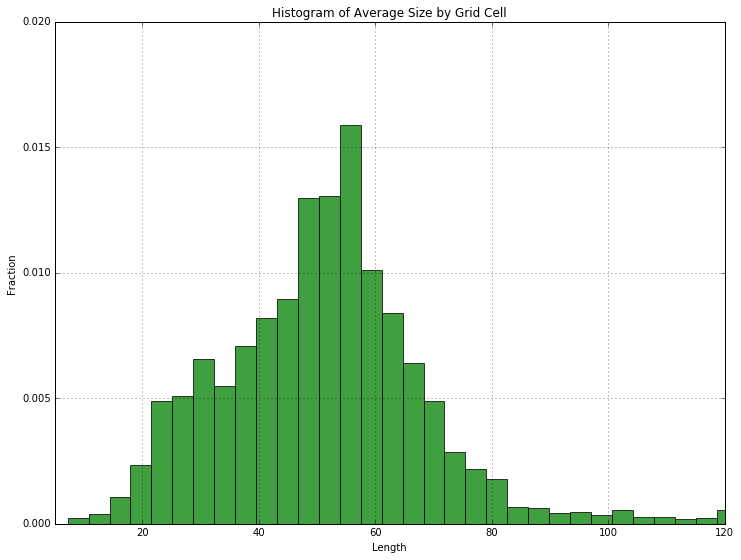

In [50]:
# the histogram of the data
n, bins, patches = plt.hist(grid2, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
# y = mlab.normpdf( bins, mu, sigma)
# l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Length')
plt.ylabel('Fraction')
plt.title(r'Histogram of Average Size by Grid Cell')
plt.axis([5, 120, 0, 0.02])
plt.grid(True)

plt.show()